<a href="https://colab.research.google.com/github/InsightofSPb/PyTorch_Study/blob/main/LSTM/%D0%9B%D0%B0%D0%B1%D0%BE%D1%80%D0%B0%D1%82%D0%BE%D1%80%D0%BD%D0%B0%D1%8F_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Цель работы**

Целью данной лабораторной работы является изучение принципов работы рекуррентных нейронных сетей и применение их для решения задачи классификации текстов.

**Задача**

В данной работе необходимо предстоит решить задачу классификации текстов на два класса: положительный и отрицательный отзыв. Для этого Вам будет предложен набор данных IMDB из tensorflow.keras.datasets, который необходимо обработать и разделить на тренировочную и тестовую выборки.

**Для этого:**

- Загрузить и проанализировать данные набора данных IMDB.
- Предобработать данные: преобразовать текстовые данные в числовой формат, нормализовать данные и т.д.
- Разбить данные на обучающую и тестовую выборки.
- Создать и обучить базовую рекуррентную нейронную сеть для классификации отзывов.
- Оценить качество модели на тестовой выборке.
- Попробовать улучшить качество модели, экспериментируя с гиперпараметрами и архитектурой модели.

Загружаем библиотеки

In [ ]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt


device = "cuda" if torch.cuda.is_available() else "cpu"

Задаём ограничения на максимальную длину отзыва в словах, на общее число слов в словаре

In [ ]:
# настройки загрузки данных
number_of_words = 20000  # ограничение на количество слов
max_len = 300  # максимальная длина отзыва в словах
batch_size = 32

# загрузка данных и разделение на обучающую и тестовую выборки
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=number_of_words)
# ограничение длины отзывов
X_train = sequence.pad_sequences(X_train, maxlen=max_len)
X_test = sequence.pad_sequences(X_test, maxlen=max_len)
y_train = np.asarray(y_train).astype('float32')  # перевод во float32, чтобы не ругался на размерности
y_test = np.asarray(y_test).astype('float32')

17464789/17464789 [==============================] - 0s 0us/step


Создаём датасет из обучающей выборки и разделим его на порции

In [ ]:
X_train, y_train = torch.tensor(X_train).to(device), torch.tensor(y_train).to(device)   # перевод в тензоры и на девайс
train_dataset = TensorDataset(X_train, y_train)  # создаём датасет
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)   # делим на батчи

Создаём датасет из тестовой выборки и разделим его на порции

In [ ]:
X_test, y_test = torch.tensor(X_test).to(device), torch.tensor(y_test).to(device)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

**Зададим модель**

LSTM будет двунаправленной и состоять из двух слоёв. Размерность эмбеддинга 256, глубина скрытого слоя 256. 

In [ ]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim=embedding_dim)  # эмбеддинг
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, bidirectional=True, batch_first=True)   # сама LSTM
        self.lin = nn.Linear(hidden_dim * 2, output_dim)  # линейный слой
        self.sig = nn.Sigmoid()  # сигмоида

    def forward(self, text):
        embedded = self.embedding(text)
        output, (hidden, cell) = self.lstm(embedded)
        hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)   # поскольку слоёв 2, необходимо итоговый тензор получить их объединением
        linear = self.lin(hidden)
        return self.sig(linear)


vocab_size = 25000
embedding_dim = 256
hidden_dim = 256
output_dim = 1
n_layers = 2


model = LSTM(vocab_size, embedding_dim, hidden_dim, output_dim).to(device)

Задание числа эпох, функции потерь - Бинарной кросс энтропии. Оптимизатор - стохастический градиентный спуск

In [ ]:
epochs = 30

optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)
loss_fn = nn.BCELoss()
f1_tr, acc_tr, loss_tr, f1_test, acc_test, loss_test = [], [], [], [], [], []

Процесс обучения модели, структура аналогична прошлой работе

In [ ]:
for epoch in range(epochs):
    train_loss = 0
    y_true = []
    y_pred = []
    model.train()
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        pred = model(X).squeeze()

        loss = loss_fn(pred, y.float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * y.size(0)
        y_true.extend(y.tolist())
        y_pred.extend(torch.round(pred).tolist())
        if len(y_true) % 6000 == 0:
            print(f'Прошло {len(y_true)} отзывов в эпохе {epoch + 1}')
    train_loss = train_loss / len(train_loader)
    loss_tr.append(train_loss)
    f1_tr.append(f1_score(y_true, y_pred, average='macro'))
    acc_tr.append(accuracy_score(y_true, y_pred))
    trainTemplate = "epoch: {} | train loss: {:.3f} | train accuracy: {:.3f} | train f1: {:.3f}"
    print(trainTemplate.format(epoch + 1, train_loss, acc_tr[-1], f1_tr[-1]))

    model.eval()
    with torch.no_grad():
      test_loss = 0
      for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        predictions = model(inputs)
        loss = loss_fn(predictions.squeeze(), targets)
        test_loss += loss.item() * targets.size(0)
        _, predicted = torch.max(predictions.data, 1)
        y_true.extend(targets.tolist())
        y_pred.extend(predicted.tolist())
      test_loss /= len(test_loader)
      loss_test.append(test_loss)
      f1_test.append(f1_score(y_true, y_pred, average='macro'))
      acc_test.append(accuracy_score(y_true, y_pred))
      valTemplate = "epoch: {} | test loss: {:.3f} | test accuracy: {:.3f} | test f1: {:.3f}"
      print(valTemplate.format(epoch + 1, test_loss, acc_test[-1], f1_test[-1]))

Прошло 12000 отзывов в эпохе 1
Прошло 24000 отзывов в эпохе 1
epoch: 1 | train loss: 21.696 | train accuracy: 0.562 | train f1: 0.561
epoch: 1 | test loss: 20.446 | test accuracy: 0.531 | test f1: 0.498
Прошло 12000 отзывов в эпохе 2
Прошло 24000 отзывов в эпохе 2
epoch: 2 | train loss: 18.812 | train accuracy: 0.684 | train f1: 0.684
epoch: 2 | test loss: 17.711 | test accuracy: 0.592 | test f1: 0.565
Прошло 12000 отзывов в эпохе 3
Прошло 24000 отзывов в эпохе 3
epoch: 3 | train loss: 19.660 | train accuracy: 0.651 | train f1: 0.651
epoch: 3 | test loss: 22.184 | test accuracy: 0.575 | test f1: 0.548
Прошло 12000 отзывов в эпохе 4
Прошло 24000 отзывов в эпохе 4
epoch: 4 | train loss: 19.140 | train accuracy: 0.667 | train f1: 0.667
epoch: 4 | test loss: 17.820 | test accuracy: 0.583 | test f1: 0.556
Прошло 12000 отзывов в эпохе 5
Прошло 24000 отзывов в эпохе 5
epoch: 5 | train loss: 17.645 | train accuracy: 0.711 | train f1: 0.711
epoch: 5 | test loss: 16.636 | test accuracy: 0.605 | 

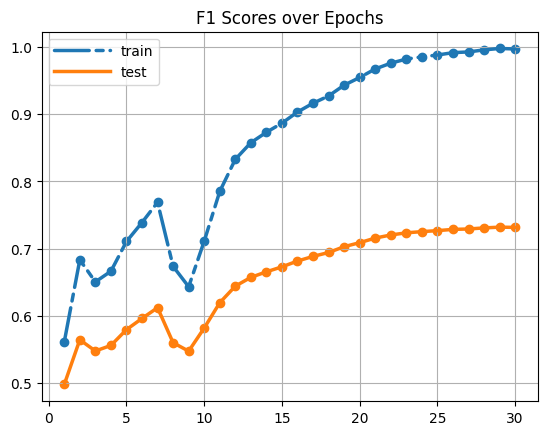

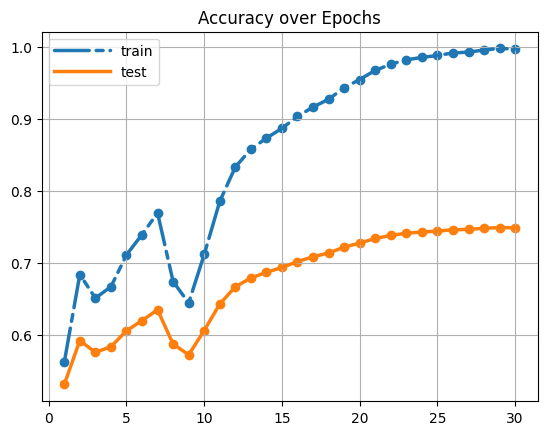

In [ ]:
def plot_help(epochs, y_train_m, y_test_m, title):
    plt.rc('lines', linewidth=2.5)
    fig, ax = plt.subplots()
    ax.set_title(title)
    line1, = ax.plot(np.linspace(1, epochs, num=epochs), y_train_m, label='train')
    line1.set_dashes([10, 2, 2, 2])  # 10pt line, 2pt break, 2pt line, 2pt break.
    line1.set_dash_capstyle('round')
    ax.scatter(np.linspace(1, epochs, num=epochs), y_train_m)
    line2, = ax.plot(np.linspace(1, epochs, num=epochs), y_test_m, label='test')
    ax.scatter(np.linspace(1, epochs, num=epochs), y_test_m)
    ax.legend(handlelength=4)
    plt.grid()
    return fig, ax


title = 'F1 Scores over Epochs'
fig1, ax1 = plot_help(epochs, f1_tr, f1_test, title)
title = 'Accuracy over Epochs'
fig3, ax3 = plot_help(epochs, acc_tr, acc_test, title)
plt.show()
torch.save(model.state_dict(), 'model.pth')

**Выводы:**
В ходе выполнения лабораторной работы была построена модель LSTM. В результате обучения на валидационной выборке точность составила 74,8%. Для того, чтобы обеспечить данную точность было увеличено число слоёв с 1 до 2, размерность эмбеддинга и скрытого слоя увеличина до 256, количество эпох принято равным 30. Также была увеличена ма